<a href="https://colab.research.google.com/github/sonisimran05/DataScience/blob/main/Health_Insurance_Lead_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rizdelhi_jobathon_data_path = kagglehub.dataset_download('rizdelhi/jobathon-data')

print('Data source import complete.')


100%|██████████| 1.12M/1.12M [00:00<00:00, 105MB/s]

Extracting files...
Data source import complete.


# Health Insurance Lead Prediction

__FinMan__ is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company.

The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

I am building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

Demographics (city, age, region etc.)
Information regarding holding policies of the customer
Recommended Policy Information

The evaluation metric for this data is __roc_auc_score__ across all entries in the test set.

### Train Data Description

ID - Unique Identifier for a row

City_Code - Code for the City of the customers

Region_Code - Code for the Region of the customers

Accomodation_Type - Customer Owns or Rents the house

Reco_Insurance_Type	- Joint or Individual type for the recommended insurance  

Upper_Age - Maximum age of the customer

Lower _Age - Minimum age of the customer

Is_Spouse - If the customers are married to each other(in case of joint insurance)

Health_Indicator - Encoded values for health of the customer

Holding_Policy_Duration	Duration - (in years) of holding policy (a policy that customer has already subscribed to with the company)

Holding_Policy_Type - Type of holding policy

Reco_Policy_Cat	- Encoded value for recommended health insurance

Reco_Policy_Premium	- Annual Premium (INR) for the recommended health insurance

>### Response (Target)

0 : Customer did not show interest in the recommended policy

1 : Customer showed interest in the recommended policy

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,gc,re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score


import lightgbm as lgb
from numpy import mean
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

#### The warnings from Sklearn shut off #######
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [9]:
def load_data():
    train = pd.read_csv("/content/Health Insurance Train Data.csv")
    test  = pd.read_csv("/content/HealthInsurance Test Data.csv")
    submission = pd.read_csv("/content/sample_submission.csv")
    return train,test,submission

In [10]:
train,_,_ = load_data()
train.head(1)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0


### convert data types

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       38000 non-null  int64  
 1   City_Code                38000 non-null  object 
 2   Region_Code              38000 non-null  int64  
 3   Accomodation_Type        38000 non-null  object 
 4   Reco_Insurance_Type      38000 non-null  object 
 5   Upper_Age                38000 non-null  int64  
 6   Lower_Age                38000 non-null  int64  
 7   Is_Spouse                38000 non-null  object 
 8   Health Indicator         29280 non-null  object 
 9   Holding_Policy_Duration  22919 non-null  object 
 10  Holding_Policy_Type      22919 non-null  float64
 11  Reco_Policy_Cat          38000 non-null  int64  
 12  Reco_Policy_Premium      38000 non-null  float64
 13  Response                 38000 non-null  int64  
dtypes: float64(2), int64(6

In [12]:
train['City_Code'] = train['City_Code'].astype('category')
train['Region_Code'] = train['Region_Code'].astype('category')
train['Accomodation_Type']=train['Accomodation_Type'].astype('category')
train['Reco_Insurance_Type'] = train['Reco_Insurance_Type'].astype('category')
train['Reco_Policy_Cat'] = train['Reco_Policy_Cat'].astype('category')
train['Is_Spouse']=train['Is_Spouse'].astype('category')

In [13]:
train['Holding_Policy_Duration'].value_counts()

,count
Holding_Policy_Duration,
1,3387
14+,3238
2,3197
3,2666
4,2097
5,1762
6,1408
7,1216
8,981


In [14]:
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].replace('14+','15') # replace 14+ with 15
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].mode()[0]) # most frequent value
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].astype('float64')
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].astype('int64')
train['Reco_Policy_Premium']=train['Reco_Policy_Premium'].astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       38000 non-null  int64   
 1   City_Code                38000 non-null  category
 2   Region_Code              38000 non-null  category
 3   Accomodation_Type        38000 non-null  category
 4   Reco_Insurance_Type      38000 non-null  category
 5   Upper_Age                38000 non-null  int64   
 6   Lower_Age                38000 non-null  int64   
 7   Is_Spouse                38000 non-null  category
 8   Health Indicator         29280 non-null  object  
 9   Holding_Policy_Duration  38000 non-null  int64   
 10  Holding_Policy_Type      22919 non-null  float64 
 11  Reco_Policy_Cat          38000 non-null  category
 12  Reco_Policy_Premium      38000 non-null  int64   
 13  Response                 38000 non-null  int64   
dtypes: cat

### NA values

In [15]:
#  NA counts
print('Health Indicator',train['Health Indicator'].isna().sum()/train.shape[0])
print('Holding_Policy_Type',train['Holding_Policy_Type'].isna().sum()/train.shape[0])

Health Indicator 0.2294736842105263
Holding_Policy_Type 0.3968684210526316


In [16]:
## Replace NAN values with Unknown

train['Health Indicator'] = np.where(train['Health Indicator'].isnull(),"Unknown",train['Health Indicator'])
train['Health Indicator'].value_counts()
train['Health Indicator'] = train['Health Indicator'].astype('category')

In [17]:
train['Holding_Policy_Type'].value_counts()

,count
Holding_Policy_Type,
3.0,9898
1.0,6184
2.0,3739
4.0,3098


In [18]:
#fill NA values with most frequent

train['Holding_Policy_Type']=train['Holding_Policy_Type'].fillna(train['Holding_Policy_Type'].mode()[0]) # most frequent value
train['Holding_Policy_Type']=train['Holding_Policy_Type'].astype('int64')
train['Holding_Policy_Type']=train['Holding_Policy_Type'].astype('category')
train['Response']=train['Response'].astype('category')

In [19]:
train["Average_age"]=train[['Upper_Age','Lower_Age']].mean(axis=1)

In [20]:
train.head(1)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,1,C3,3213,Rented,Individual,36,36,No,X1,15,3,22,11628,0,36.0


## Mutual Information

In [21]:
from sklearn.feature_selection import mutual_info_classif

In [22]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [23]:
train_data = train.copy()
train_data.drop(["ID"],axis=1,inplace=True)
y=train_data.pop('Response')
X=train_data
scores = make_mi_scores(X,y)
scores

,MI Scores
Reco_Policy_Premium,0.091941
Region_Code,0.076148
Reco_Policy_Cat,0.023760
Lower_Age,0.001046
Upper_Age,0.000991
City_Code,0.000307
Health Indicator,0.000194
Holding_Policy_Duration,0.000176
Reco_Insurance_Type,0.000041
Holding_Policy_Type,0.000021


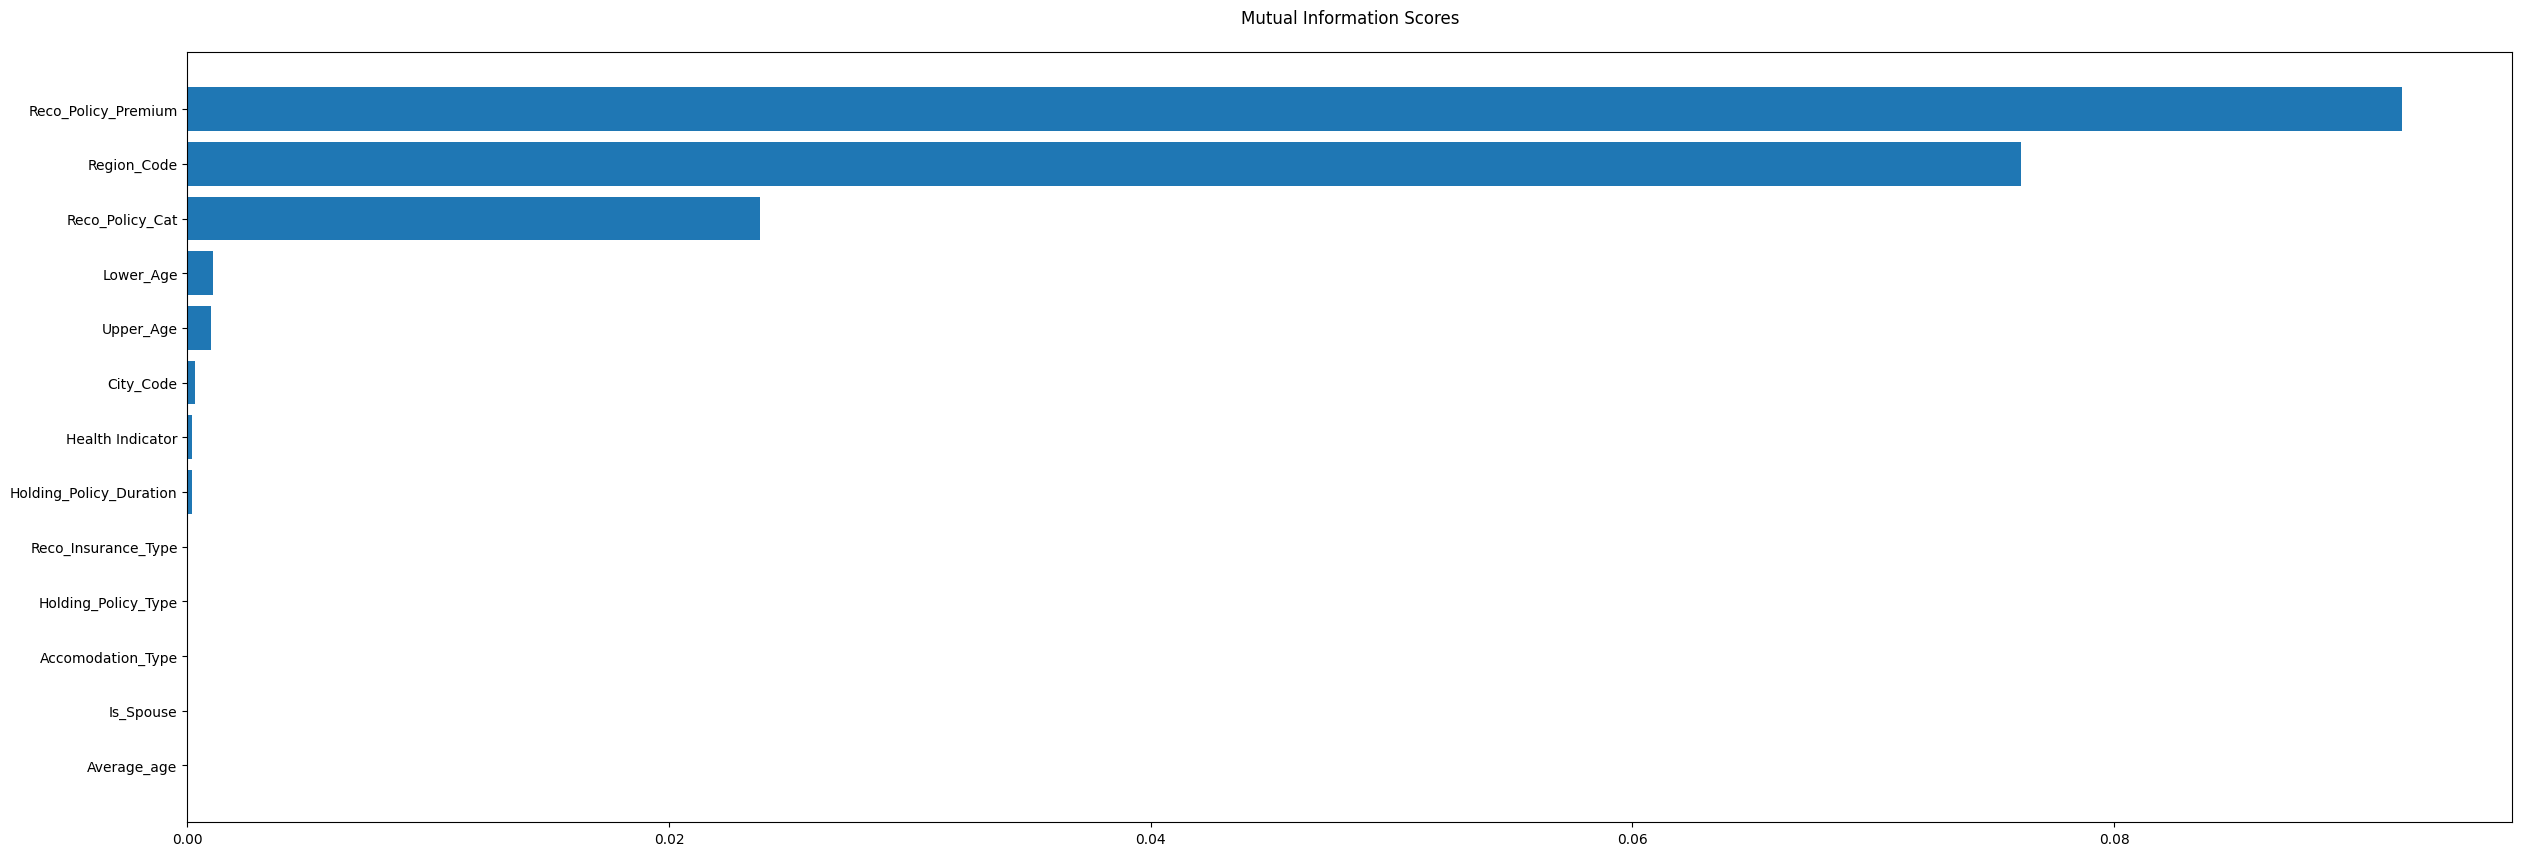

In [24]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    color = np.array(["C0"] * scores.shape[0])
    # Color red for probes
    idx = [i for i, col in enumerate(scores.index)
           if col.startswith("PROBE")]
    color[idx] = "C3"
    # Create plot
    plt.figure(figsize=(30,10))
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores\n")

plot_mi_scores(scores)

In [25]:
# removing least important features

train.drop(['Is_Spouse','Accomodation_Type','Holding_Policy_Type','Reco_Insurance_Type'],axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       38000 non-null  int64   
 1   City_Code                38000 non-null  category
 2   Region_Code              38000 non-null  category
 3   Upper_Age                38000 non-null  int64   
 4   Lower_Age                38000 non-null  int64   
 5   Health Indicator         38000 non-null  category
 6   Holding_Policy_Duration  38000 non-null  int64   
 7   Reco_Policy_Cat          38000 non-null  category
 8   Reco_Policy_Premium      38000 non-null  int64   
 9   Response                 38000 non-null  category
 10  Average_age              38000 non-null  float64 
dtypes: category(5), float64(1), int64(5)
memory usage: 2.1 MB


In [26]:
# processed data set
train.to_csv("train.csv",index=False)

In [27]:
del train
gc.collect()

4010

# Model Training without Feature Engineering

I am removing the least important features step by step

In [28]:
train = pd.read_csv("train.csv")
train.drop(["ID"],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))

train.head(1)

,City_Code,Region_Code,Upper_Age,Lower_Age,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,36,36,1,15,22,11628,0,36.0


In [29]:
scores[scores>0.00005]

,MI Scores
Reco_Policy_Premium,0.091941
Region_Code,0.076148
Reco_Policy_Cat,0.023760
Lower_Age,0.001046
Upper_Age,0.000991
City_Code,0.000307
Health Indicator,0.000194
Holding_Policy_Duration,0.000176


In [30]:
RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]
len(preds)

9

# XGBoost Classifier

### SMOTE balance

In [31]:
from collections import Counter
from imblearn.over_sampling import SMOTE


# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 28932, 1: 9068})
Resampled dataset shape Counter({0: 26348, 1: 26348})
(39522, 9) (39522,)


In [32]:
import xgboost as xgb
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')

xgmodel.fit(X_train,y_train)
from sklearn.metrics import balanced_accuracy_score, accuracy_score
print('ROC_AUC:',roc_auc_score(y_test,xgmodel.predict(X_test)))

ROC_AUC: 0.6748593534906995


## RandomOverSampler

In [33]:
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
traindf,target = oversample.fit_resample(train[preds],train[target])
# summarize class distribution
counter = Counter(target)
print(counter)

Counter({0: 28932, 1: 28932})


In [34]:
X_train,X_test,y_train,y_test= train_test_split(traindf, target,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

(43398, 9) (43398,)


In [35]:
xgmodel.fit(X_train,y_train)
print('ROC_AUC:',roc_auc_score(y_test,xgmodel.predict(X_test)))

ROC_AUC: 0.5855511795369024


In [36]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

91

### SMOTE produced better result than that of RandomOverSampler

## Removing other least important features

In [37]:
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration'],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))

train.head(1)

,City_Code,Region_Code,Upper_Age,Lower_Age,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,36,36,1,22,11628,0,36.0


In [38]:
from collections import Counter
from imblearn.over_sampling import SMOTE

RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 28932, 1: 9068})
Resampled dataset shape Counter({0: 26277, 1: 26277})
(39415, 8) (39415,)


In [39]:
import xgboost as xgb
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')
xgmodel.fit(X_train,y_train)
from sklearn.metrics import balanced_accuracy_score, accuracy_score
print('ROC_AUC:',roc_auc_score(y_test,xgmodel.predict(X_test)))

ROC_AUC: 0.6599435571276069


In [40]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

67

# Selected data set

In [41]:
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)
for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))

#train.to_csv('final_train.csv',index=False)
train.head(1)

,City_Code,Region_Code,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,1,22,11628,0,36.0


In [42]:
RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 28932, 1: 9068})
Resampled dataset shape Counter({0: 26019, 1: 26019})
(39028, 6) (39028,)


### XGBoost

In [43]:
import xgboost as xgb
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')
xgmodel.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,xgmodel.predict(X_test)),6))
print("Accuracy:",round(accuracy_score(y_test,xgmodel.predict(X_test)),6))

ROC_AUC: 0.663413
Accuracy: 0.663413


### CatBoost Classifier

## Gradient Boost Classifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
#Gradient Boosting Classifier

gb_model1 = GradientBoostingClassifier(n_estimators=500,max_depth=11)
gb_model1.fit(X_train,y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,gb_model1.predict(X_test)),6))

ROC_AUC: 0.832283


In [47]:
# selected for the final model
# train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)

## LightGBM

In [48]:
import lightgbm as lgb
model_clf = lgb.LGBMClassifier()
model_clf.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,model_clf.predict(X_test)),6))

[LightGBM] [Info] Number of positive: 19713, number of negative: 19695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 39408, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500228 -> initscore=0.000914
[LightGBM] [Info] Start training from score 0.000914
ROC_AUC: 0.78363


In [ ]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

### Removing Health Indicator

In [46]:
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True) # selected this data set

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))


RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 28932, 1: 9068})
Resampled dataset shape Counter({0: 26272, 1: 26272})
(39408, 7) (39408,)


In [49]:
train.head(1)

,City_Code,Region_Code,Upper_Age,Lower_Age,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,36,36,22,11628,0,36.0


## XGBoost

In [50]:
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')
xgmodel.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,xgmodel.predict(X_test)),6))
print("Accuracy:",round(accuracy_score(y_test,xgmodel.predict(X_test)),6))

ROC_AUC: 0.664747
Accuracy: 0.664738


## CatBoost Classifier

In [52]:
!pip install catboost -q #installing the missing catboost library
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,catboost.predict(X_test)),6))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00
Learning rate set to 0.049459
0:	learn: 0.6869092	total: 71.9ms	remaining: 1m 11s
100:	learn: 0.5611897	total: 1.34s	remaining: 12s
200:	learn: 0.5191682	total: 2.67s	remaining: 10.6s
300:	learn: 0.4842091	total: 4.11s	remaining: 9.55s
400:	learn: 0.4563649	total: 5.89s	remaining: 8.79s
500:	learn: 0.4370735	total: 7.31s	remaining: 7.28s
600:	learn: 0.4235529	total: 9.96s	remaining: 6.62s
700:	learn: 0.4119830	total: 11.4s	remaining: 4.87s
800:	learn: 0.3999969	total: 12.5s	remaining: 3.1s
900:	learn: 0.3908634	total: 13.6s	remaining: 1.49s
999:	learn: 0.3828267	total: 14.6s	remaining: 0us
ROC_AUC: 0.810005


In [53]:
# train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True)
# Catboost model with this data set is selected for hyperparameter tuning with optuna

## Gradient Boosting

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
#Gradient Boosting Classifier

gb_model2 = GradientBoostingClassifier(n_estimators=250,max_depth=10)
gb_model2.fit(X_train,y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,gb_model2.predict(X_test)),6))

ROC_AUC: 0.827331


## Light GBM


In [55]:
import lightgbm as lgb

model_clf = lgb.LGBMClassifier()
model_clf.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,model_clf.predict(X_test)),6))

[LightGBM] [Info] Number of positive: 19713, number of negative: 19695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 39408, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500228 -> initscore=0.000914
[LightGBM] [Info] Start training from score 0.000914
ROC_AUC: 0.78363


In [56]:
# selected for the final model
# train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True)

In [57]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

67

In [58]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.5 MB/s eta 0:00:00


# Final Model

## CatBoost and Light GBM with 7 features

In [59]:
RANDOM_SEED = 99

train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True)


for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))

target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,catboost.predict(X_test)),6))

Original dataset shape Counter({0: 28932, 1: 9068})
Resampled dataset shape Counter({0: 26272, 1: 26272})
(39408, 7) (39408,)
Learning rate set to 0.049459
0:	learn: 0.6869092	total: 40.9ms	remaining: 40.9s
100:	learn: 0.5611897	total: 3.08s	remaining: 27.4s
200:	learn: 0.5191682	total: 9.67s	remaining: 38.4s
300:	learn: 0.4842091	total: 13.9s	remaining: 32.3s
400:	learn: 0.4563649	total: 18.5s	remaining: 27.6s
500:	learn: 0.4370735	total: 25s	remaining: 24.9s
600:	learn: 0.4235529	total: 29.7s	remaining: 19.7s
700:	learn: 0.4119830	total: 35.9s	remaining: 15.3s
800:	learn: 0.3999969	total: 40.6s	remaining: 10.1s
900:	learn: 0.3908634	total: 45s	remaining: 4.95s
999:	learn: 0.3828267	total: 50.6s	remaining: 0us
ROC_AUC: 0.810005


In [60]:
import catboost as cb
import optuna


def objective(trial):
    data, target = X_res, y_res
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-04-23 06:46:45,942] A new study created in memory with name: no-name-53a9e383-e0d9-4ea5-8cfd-3b35a8407e2c
[I 2025-04-23 06:47:13,629] Trial 0 finished with value: 0.6342933265668612 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07526720377772154, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6342933265668612.
[I 2025-04-23 06:47:26,047] Trial 1 finished with value: 0.6458386196396854 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06604695896675128, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.6458386196396854.
[I 2025-04-23 06:47:33,279] Trial 2 finished with value: 0.6352448617102259 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04319333203976831, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.6458386196396854.
[I 2025-04-23 06:48:03,460] Trial 3 finished with valu

Number of finished trials: 26
Best trial:
  Value: 0.7136513575234712
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09391718766817551
    depth: 7
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.8488393243408746


In [61]:
import catboost as cb
Params = study.best_trial.params
cbopt = cb.CatBoostClassifier(**Params)
cbopt.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,cbopt.predict(X_test)),6))

Learning rate set to 0.049459
0:	learn: 0.6928001	total: 27.1ms	remaining: 27s
100:	learn: 0.6510713	total: 2.58s	remaining: 23s
200:	learn: 0.6333741	total: 6.22s	remaining: 24.7s
300:	learn: 0.6217125	total: 8.69s	remaining: 20.2s
400:	learn: 0.6125546	total: 11.2s	remaining: 16.7s
500:	learn: 0.6060907	total: 13.6s	remaining: 13.6s
600:	learn: 0.6014206	total: 16.7s	remaining: 11.1s
700:	learn: 0.5943211	total: 19.8s	remaining: 8.46s
800:	learn: 0.5875822	total: 22.2s	remaining: 5.53s
900:	learn: 0.5840424	total: 24.7s	remaining: 2.71s
999:	learn: 0.5796239	total: 27.1s	remaining: 0us
ROC_AUC: 0.689275


In [62]:
import lightgbm as lgb

model_clf = lgb.LGBMClassifier()
model_clf.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,model_clf.predict(X_test)),6))

[LightGBM] [Info] Number of positive: 19713, number of negative: 19695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 39408, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500228 -> initscore=0.000914
[LightGBM] [Info] Start training from score 0.000914
ROC_AUC: 0.78363


## Gradient Boost with 6 features

In [63]:
RANDOM_SEED = 99
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))

target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 28932, 1: 9068})
Resampled dataset shape Counter({0: 26019, 1: 26019})
(39028, 6) (39028,)


In [64]:
preds

['City_Code',
 'Region_Code',
 'Health Indicator',
 'Reco_Policy_Cat',
 'Reco_Policy_Premium',
 'Average_age']

In [65]:
gb_model1 = GradientBoostingClassifier(n_estimators=500,max_depth=11)
gb_model1.fit(X_train,y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,gb_model1.predict(X_test)),6))

ROC_AUC: 0.834128


In [66]:
gc.collect()

0

In [67]:
from sklearn.ensemble import StackingClassifier

estimators = [('cb',catboost),('lgb',model_clf)]

clf = StackingClassifier(estimators=estimators, final_estimator= gb_model1)
clf.fit(X_train, y_train).score(X_test, y_test)

Streaming output truncated to the last 5000 lines.
43:	learn: 0.6094624	total: 379ms	remaining: 8.23s
44:	learn: 0.6088934	total: 387ms	remaining: 8.21s
45:	learn: 0.6083771	total: 395ms	remaining: 8.19s
46:	learn: 0.6079082	total: 409ms	remaining: 8.29s
47:	learn: 0.6073100	total: 418ms	remaining: 8.28s
48:	learn: 0.6062952	total: 426ms	remaining: 8.27s
49:	learn: 0.6054902	total: 434ms	remaining: 8.25s
50:	learn: 0.6048384	total: 448ms	remaining: 8.33s
51:	learn: 0.6043329	total: 459ms	remaining: 8.37s
52:	learn: 0.6037900	total: 469ms	remaining: 8.38s
53:	learn: 0.6026971	total: 482ms	remaining: 8.44s
54:	learn: 0.6018442	total: 495ms	remaining: 8.5s
55:	learn: 0.6010508	total: 506ms	remaining: 8.53s
56:	learn: 0.6005688	total: 518ms	remaining: 8.56s
57:	learn: 0.5993183	total: 526ms	remaining: 8.54s
58:	learn: 0.5985538	total: 534ms	remaining: 8.51s
59:	learn: 0.5981330	total: 542ms	remaining: 8.49s
60:	learn: 0.5971830	total: 550ms	remaining: 8.46s
61:	learn: 0.5968604	total: 558m

0.7864719446579554

In [68]:
params = clf.get_params(deep=True)
print('ROC_AUC:',round(roc_auc_score(y_test,clf.predict(X_test)),6))

ROC_AUC: 0.786472


# Submissions

In [69]:
_,testf,submission = load_data()
testf["Average_age"]=testf[['Upper_Age','Lower_Age']].mean(axis=1)
testf.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age',
            'Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Type','Is_Spouse'],axis=1,inplace=True)


for c in testf.columns:
    if testf[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(testf[c].values))
        testf[c]= le.transform(list(testf[c].values))


testf.to_csv('final_test.csv',index=False)
testf.head(1)

,City_Code,Region_Code,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Average_age
0,6,620,3,19,30768.0,47.0


In [70]:
submission.head(2)

,38001,0
0,38002,0
1,38003,1


In [72]:
# Assuming testf has the extra row, remove it to match submission's length
testf = testf.iloc[:-1, :]  # Remove the last row

predclf = clf.predict(testf)
submission['Response'] = predclf
submission.to_csv("submission_stacked.csv", index=False)

In [75]:
# catboost
_,testf,submission = load_data() # Reload the original test data to include 'Upper_Age'
testf["Average_age"]=testf[['Upper_Age','Lower_Age']].mean(axis=1)
testf.drop(["ID",'Holding_Policy_Duration','Health Indicator', # Keep 'Upper_Age' and 'Lower_Age'
            'Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Type','Is_Spouse'],axis=1,inplace=True)


for c in testf.columns:
    if testf[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(testf[c].values))
        testf[c]= le.transform(list(testf[c].values))

# Assuming testf has the extra row, remove it to match submission's length
testf = testf.iloc[:-1, :]  # Remove the last row

predictions = catboost.predict(testf) # Changed RFC to catboost
submission['Response'] = predictions
submission.to_csv("submission_cat4.csv",index=False)

# Appendix A

In [78]:
#### requirements
#ipython
#jupyter
#xgboost>=1.1.1
#pandas
#matplotlib
#seaborn
#scikit-learn>=0.23.1
#networkx
#category_encoders

!pip install xlrd -q
!pip install git+https://github.com/AutoViML/featurewiz.git -q
!pip install category_encoders -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/

In [79]:
import category_encoders
import xgboost
import networkx as nx
from xgboost.sklearn import XGBClassifier
from category_encoders import OneHotEncoder

In [80]:
# selected data set

train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))


from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.2,random_state=RANDOM_SEED)
print(train.shape, test.shape)

(30400, 7) (7600, 7)


Imported lazytransform v1.18. 

Imported featurewiz 0.6.1. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
    Single_Label Binary_Classification problem 
    Loaded train data. Shap

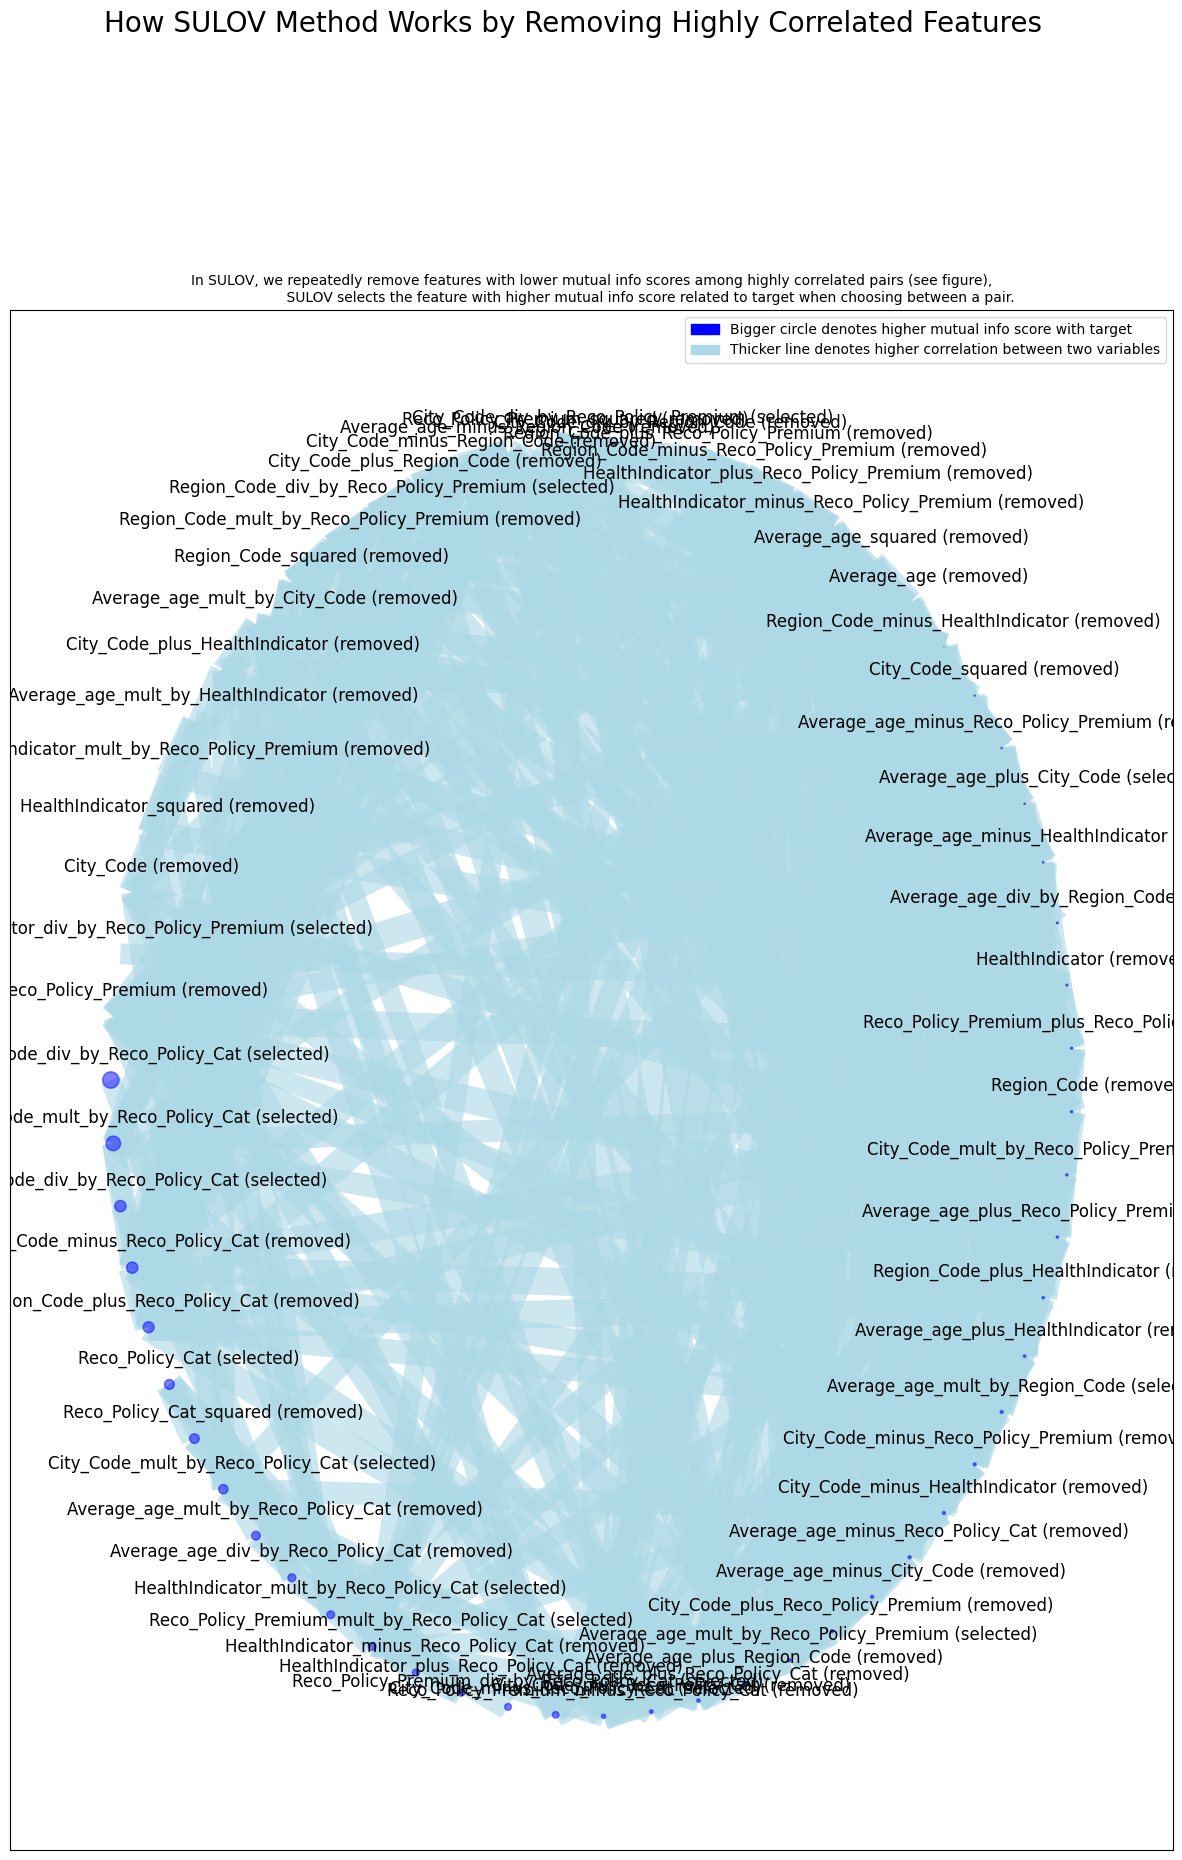

Time taken for SULOV method = 30 seconds
    Adding 0 categorical variables to reduced numeric variables  of 25
Final list of selected 25 vars after SULOV = ['Average_age_div_by_City_Code', 'Average_age_div_by_HealthIndicator', 'Average_age_div_by_Reco_Policy_Premium', 'City_Code_mult_by_Region_Code', 'City_Code_div_by_HealthIndicator', 'City_Code_mult_by_HealthIndicator', 'Region_Code_div_by_HealthIndicator', 'Region_Code_mult_by_HealthIndicator', 'HealthIndicator_div_by_Reco_Policy_Cat', 'Region_Code_div_by_Reco_Policy_Cat', 'Region_Code_mult_by_Reco_Policy_Cat', 'City_Code_div_by_Reco_Policy_Cat', 'Reco_Policy_Cat', 'City_Code_mult_by_Reco_Policy_Cat', 'HealthIndicator_mult_by_Reco_Policy_Cat', 'Reco_Policy_Premium_mult_by_Reco_Policy_Cat', 'Reco_Policy_Premium_div_by_Reco_Policy_Cat', 'City_Code_minus_Reco_Policy_Cat', 'Average_age_mult_by_Reco_Policy_Premium', 'Average_age_mult_by_Region_Code', 'Average_age_div_by_Region_Code', 'Average_age_plus_City_Code', 'City_Code_div_by_Reco_

In [84]:
!pip install tensorflow
from featurewiz import featurewiz

RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

output = featurewiz(train, target, corr_limit=0.70,verbose=1, test_data=test,
                      feature_engg=["groupby",'target','interactions'],
                     category_encoders='OneHotEncoder'
                     )

# CatBoost with Feature Engineering

In [85]:
trainm,testm= output

In [86]:
RANDOM_SEED = 101
target = 'Response'
preds = [x for x in list(trainm) if x != target]

trainm, testm = train_test_split(trainm, test_size=0.2,random_state=RANDOM_SEED)
print(trainm.shape, testm.shape)

(24320, 18) (6080, 18)


In [87]:
# number of features

cat_vars = trainm.select_dtypes(include='category').columns.tolist() + trainm.select_dtypes(include='object').columns.tolist()
trainm[cat_vars]=trainm[cat_vars].fillna(trainm.mean().iloc[0])
feats = [x for x in list(trainm) if x not in [target]]
len(feats)

17

In [88]:
feats

['Reco_Policy_Cat',
 'Region_Code_mult_by_Reco_Policy_Cat',
 'Average_age_div_by_City_Code',
 'Average_age_div_by_Reco_Policy_Premium',
 'Region_Code_div_by_Reco_Policy_Cat',
 'Region_Code_div_by_HealthIndicator',
 'Average_age_mult_by_Reco_Policy_Premium',
 'City_Code_div_by_Reco_Policy_Cat',
 'Average_age_div_by_Region_Code',
 'HealthIndicator_div_by_Reco_Policy_Premium',
 'Reco_Policy_Premium_mult_by_Reco_Policy_Cat',
 'Reco_Policy_Premium_div_by_Reco_Policy_Cat',
 'City_Code_minus_Reco_Policy_Cat',
 'Average_age_mult_by_Region_Code',
 'Average_age_plus_City_Code',
 'City_Code_div_by_Reco_Policy_Premium',
 'Region_Code_div_by_Reco_Policy_Premium']

In [92]:
RFC = CatBoostClassifier()
RFC.fit(trainm[feats],trainm[target], metric_period=100)

Learning rate set to 0.040248
0:	learn: 0.6792354	total: 67.1ms	remaining: 1m 7s
100:	learn: 0.5215537	total: 4.2s	remaining: 37.4s
200:	learn: 0.5106971	total: 6.58s	remaining: 26.2s
300:	learn: 0.5003746	total: 9.33s	remaining: 21.7s
400:	learn: 0.4902736	total: 11.9s	remaining: 17.7s
500:	learn: 0.4807123	total: 15.9s	remaining: 15.8s
600:	learn: 0.4717479	total: 17.4s	remaining: 11.6s
700:	learn: 0.4629044	total: 18.6s	remaining: 7.93s
800:	learn: 0.4546215	total: 19.7s	remaining: 4.9s
900:	learn: 0.4466985	total: 22.4s	remaining: 2.46s
999:	learn: 0.4390889	total: 25.2s	remaining: 0us


In [90]:
print('ROC_AUC :',round(roc_auc_score(testm[target].values, RFC.predict(testm[feats])),6))
print("Accuracy:",round(accuracy_score(testm[target].values, RFC.predict(testm[feats])),6))

ROC_AUC : 0.511299
Accuracy: 0.755263


In [94]:
# Create a DataFrame for submission
submission = pd.DataFrame({"id": range(1, len(RFC.predict(testm[feats])) + 1), "Response": RFC.predict(testm[feats])})

# Save to CSV file
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
